In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import joblib
from sklearn.preprocessing import LabelEncoder
# Load and scale features
df = pd.read_csv("extracted_features.csv")
X = df.drop(columns=["label"]).values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "scaler.pkl")  # Ensure consistent scaling

pca = PCA(n_components=0.9) 
X_scaled = pca.fit_transform(X_scaled)
print(X_scaled.shape)
# Reduce to 2D for visualization (optional but helpful)
pca_vis = PCA(n_components=2, random_state=42)
X_pca = pca_vis.fit_transform(X_scaled)


# Store results
results = {}

(712, 11)


In [53]:
# Determine optimal k via silhouette
sil_scores_kmeans = []
k_range = range(2, 8)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil_scores_kmeans.append(silhouette_score(X_scaled, labels))

best_k = k_range[np.argmax(sil_scores_kmeans)]
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X_scaled)
results["K-Means"] = {
    "labels": labels_kmeans,
    "silhouette": max(sil_scores_kmeans),
    "k": best_k
}
print(f"K-Means: best k={best_k}, silhouette={max(sil_scores_kmeans):.3f}")

K-Means: best k=7, silhouette=0.350


In [54]:
from sklearn.mixture import GaussianMixture
sil_scores_gmm = []
bic_scores = []
for k in k_range:
    gmm = GaussianMixture(n_components=k, random_state=42, covariance_type='full')
    labels = gmm.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores_gmm.append(sil)
    bic_scores.append(gmm.bic(X_scaled))

best_k_gmm = k_range[np.argmax(sil_scores_gmm)]
gmm = GaussianMixture(n_components=best_k_gmm, random_state=42, covariance_type='full')
labels_gmm = gmm.fit_predict(X_scaled)
results["GMM"] = {
    "labels": labels_gmm,
    "silhouette": max(sil_scores_gmm),
    "k": best_k_gmm,
    "BIC": min(bic_scores)
}
print(f"GMM: best k={best_k_gmm}, silhouette={max(sil_scores_gmm):.3f}")

GMM: best k=7, silhouette=0.332


Agglomerative: best k=7, silhouette=0.349


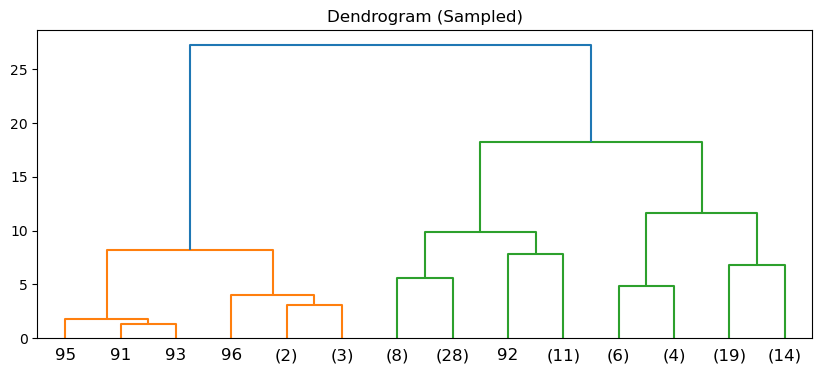

In [55]:
# Try different linkage methods; use 'ward' (requires euclidean + scaled data)
sil_scores_agg = []
for k in k_range:
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = agg.fit_predict(X_scaled)
    sil_scores_agg.append(silhouette_score(X_scaled, labels))

best_k_agg = k_range[np.argmax(sil_scores_agg)]
agg = AgglomerativeClustering(n_clusters=best_k_agg, linkage='ward')
labels_agg = agg.fit_predict(X_scaled)
results["Agglomerative"] = {
    "labels": labels_agg,
    "silhouette": max(sil_scores_agg),
    "k": best_k_agg
}
print(f"Agglomerative: best k={best_k_agg}, silhouette={max(sil_scores_agg):.3f}")

# Optional: Dendrogram (on a sample due to O(n²) cost)
if X_scaled.shape[0] <= 1000:  # Only if dataset is small
    plt.figure(figsize=(10, 4))
    linked = linkage(X_scaled[:100], method='ward')  # Sample 100 points
    dendrogram(linked, truncate_mode='level', p=3)
    plt.title("Dendrogram (Sampled)")
    plt.show()

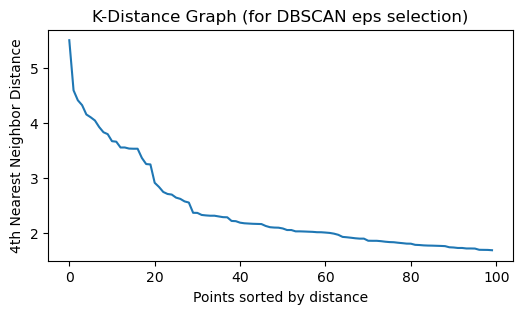

DBSCAN: 14 clusters, silhouette=0.419


In [56]:
# Tune eps using k-distance graph heuristic (k=4)
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=4)
nn.fit(X_scaled)
distances, _ = nn.kneighbors(X_scaled)
k_dist = np.sort(distances[:, -1])[::-1]

# Plot to choose eps (elbow point)
plt.figure(figsize=(6, 3))
plt.plot(k_dist[:100])  # First 100 points often enough
plt.title("K-Distance Graph (for DBSCAN eps selection)")
plt.xlabel("Points sorted by distance")
plt.ylabel("4th Nearest Neighbor Distance")
plt.show()

# Use a reasonable eps (e.g., 0.5–1.0 after inspection); min_samples=5
eps = 2.2  # Adjust based on plot
dbscan = DBSCAN(eps=eps, min_samples=8)
labels_dbscan = dbscan.fit_predict(X_scaled)
n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
sil_dbscan = silhouette_score(X_scaled, labels_dbscan) if n_clusters_dbscan > 1 else -1

results["DBSCAN"] = {
    "labels": labels_dbscan,
    "silhouette": sil_dbscan,
    "n_clusters": n_clusters_dbscan,
    "eps": eps
}
print(f"DBSCAN: {n_clusters_dbscan} clusters, silhouette={sil_dbscan:.3f}")

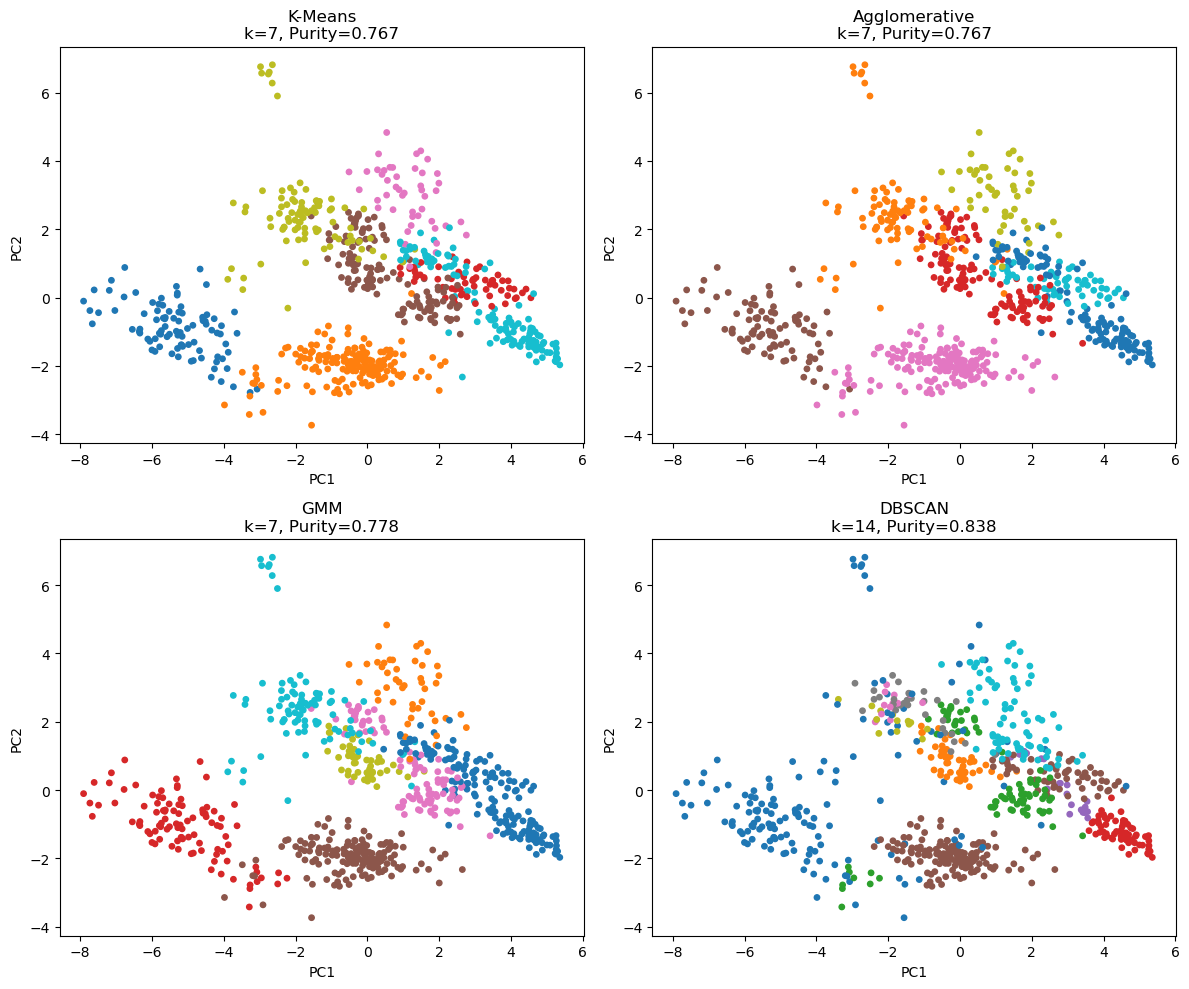

In [57]:
# First, compute purity for each method
def cluster_purity(cluster_labels, true_labels):
    total = len(true_labels)
    purity = 0
    for cluster_id in np.unique(cluster_labels):
        mask = cluster_labels == cluster_id
        cluster_true = true_labels[mask]
        if len(cluster_true) == 0:
            continue
        most_common = np.bincount(cluster_true).max()
        purity += most_common
    return purity / total

# Get true labels (encoded)
le = LabelEncoder()
true_labels = le.fit_transform(df["label"])

# Compute purity for each method and store in results
for method in results:
    labels = results[method]["labels"]
    # Handle noise points in DBSCAN (-1 labels) by excluding them or relabeling
    if method == "DBSCAN":
        # Option: treat noise as separate cluster or ignore
        # Here, we keep -1 as a valid label (purity will be low if many noise points)
        pass
    purity = cluster_purity(labels, true_labels)
    results[method]["purity"] = purity

# Now plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()
methods = ["K-Means", "Agglomerative", "GMM", "DBSCAN"]

for i, method in enumerate(methods):
    if method in results:
        labels = results[method]["labels"]
        scatter = axes[i].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap="tab10", s=15)
        
        # Get k or n_clusters
        k_val = results[method].get('k', results[method].get('n_clusters', '?'))
        purity_val = results[method]["purity"]
        
        axes[i].set_title(f"{method}\nk={k_val}, Purity={purity_val:.3f}")
        axes[i].set_xlabel("PC1")
        axes[i].set_ylabel("PC2")
    else:
        axes[i].axis('off')  # skip unused subplot

plt.tight_layout()
plt.show()